In [83]:
# 1. Data Import & Cleaning (ETL)
# 2. Merge & Monthly Alignment
# 3. Time Series Visualisation
# 4. Correlation Analysis
# 5. Rolling Averages (Trend Smoothing)
# 6. Lag Analysis
# 7. ARIMA Time Series Forecasting
# 8. Interpretation & Conclusion


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [85]:
from pathlib import Path
import pandas as pd

# Resolve paths relative to this notebook
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = REPO_ROOT / "Data" / "Processed"

# Load cleaned datasets
df_mort = pd.read_csv(DATA_DIR / "mortgage_clean.csv")
df_bank = pd.read_csv(DATA_DIR / "bank_rate_clean.csv")
df_cpi_clean = pd.read_csv(DATA_DIR / "cpi_clean.csv")

df_mort.head(), df_bank.head(), df_cpi_clean.head()



(         date  bank_rate  mortgage_rate_2yr  inflation_cpi_12m month_year
 0  2016-01-31        0.5               2.72                0.6   Jan 2016
 1  2016-02-29        0.5               2.70                0.6   Feb 2016
 2  2016-03-31        0.5               2.67                0.8   Mar 2016
 3  2016-04-30        0.5               2.65                0.7   Apr 2016
 4  2016-05-31        0.5               2.62                0.7   May 2016,
          date  bank_rate
 0  2016-01-31        0.5
 1  2016-02-29        0.5
 2  2016-03-31        0.5
 3  2016-04-30        0.5
 4  2016-05-31        0.5,
          date  inflation_cpi_12m
 0  2016-01-01                0.6
 1  2016-02-01                0.6
 2  2016-03-01                0.8
 3  2016-04-01                0.7
 4  2016-05-01                0.7)

In [86]:
df_mort['date'] = pd.to_datetime(df_mort['date'], errors='coerce')
df_bank['date'] = pd.to_datetime(df_bank['date'], errors='coerce')
df_cpi_clean['date'] = pd.to_datetime(df_cpi_clean['date'], errors='coerce')


In [87]:
df_master = df_bank.merge(df_mort, on="date", how="outer")
df_master = df_master.merge(df_cpi_clean, on="date", how="outer")

df_master = df_master.sort_values("date").reset_index(drop=True)
df_master.head()


,date,bank_rate_x,bank_rate_y,mortgage_rate_2yr,inflation_cpi_12m_x,month_year,inflation_cpi_12m_y
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,0.6
1,2016-01-31,0.5,0.5,2.72,0.6,Jan 2016,NaN
2,2016-02-01,NaN,NaN,NaN,NaN,NaN,0.6
3,2016-02-29,0.5,0.5,2.70,0.6,Feb 2016,NaN
4,2016-03-01,NaN,NaN,NaN,NaN,NaN,0.8


In [88]:
# I only want to keep data from 2016 onwards because this is when 
# all three datasets (bank rate, mortgage rate, CPI) overlap properly.
# Before 2016 there are lots of missing values, so removing them 
# makes the dataset cleaner and easier to analyse.

df_master = df_master[df_master["date"] >= "2016-01-01"].reset_index(drop=True)

# Show the first few rows to confirm the filter has worked
df_master.head()


,date,bank_rate_x,bank_rate_y,mortgage_rate_2yr,inflation_cpi_12m_x,month_year,inflation_cpi_12m_y
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,0.6
1,2016-01-31,0.5,0.5,2.72,0.6,Jan 2016,NaN
2,2016-02-01,NaN,NaN,NaN,NaN,NaN,0.6
3,2016-02-29,0.5,0.5,2.70,0.6,Feb 2016,NaN
4,2016-03-01,NaN,NaN,NaN,NaN,NaN,0.8


In [89]:
# --- Stabilise column names after merges (prevents KeyErrors in experiments) ---

# If merge created suffixes, normalise them
rename_map = {
    "bank_rate_x": "bank_rate",
    "inflation_cpi_12m_x": "inflation_cpi_12m",
}

df_master = df_master.rename(columns=rename_map)

# Drop duplicated columns if they exist
df_master = df_master.drop(
    columns=["bank_rate_y", "inflation_cpi_12m_y"],
    errors="ignore"
)

# Backwards-compatibility aliases (so old cells keep working)
# Some of your older plotting cells reference 'bank' or 'cpi'
if "bank" not in df_master.columns and "bank_rate" in df_master.columns:
    df_master["bank"] = df_master["bank_rate"]

if "cpi" not in df_master.columns and "inflation_cpi_12m" in df_master.columns:
    df_master["cpi"] = df_master["inflation_cpi_12m"]

df_master.columns


Index(['date', 'bank_rate', 'mortgage_rate_2yr', 'inflation_cpi_12m',
       'month_year', 'bank', 'cpi'],
      dtype='object')

In [90]:
# Convert all dates to month-end so everything lines up
df_master['date'] = df_master['date'] + pd.offsets.MonthEnd(0)


In [91]:
#creating month and year display column

df_master['month_year'] = df_master['date'].dt.strftime('%b %Y')


In [92]:
# --- Fix experimental df_master: one row per month, no duplicate NaN rows ---

# Ensure date is datetime
df_master["date"] = pd.to_datetime(df_master["date"])

# Align to month-end (safe even if already month-end)
df_master["date"] = df_master["date"].dt.to_period("M").dt.to_timestamp("M")

# Keep only the columns you actually analyse
keep_cols = ["date", "bank_rate", "mortgage_rate_2yr", "inflation_cpi_12m"]
df_master = df_master[keep_cols].copy()

# Collapse duplicates (mean ignores NaNs by default)
df_master = df_master.groupby("date", as_index=False).mean(numeric_only=True)

# Optional: fill gaps after aggregation
df_master = df_master.sort_values("date")
df_master[["bank_rate", "mortgage_rate_2yr", "inflation_cpi_12m"]] = (
    df_master[["bank_rate", "mortgage_rate_2yr", "inflation_cpi_12m"]].ffill()
)

df_master.head(10)


,date,bank_rate,mortgage_rate_2yr,inflation_cpi_12m
0,2016-01-31,0.5000,2.72,0.6
1,2016-02-29,0.5000,2.70,0.6
2,2016-03-31,0.5000,2.67,0.8
3,2016-04-30,0.5000,2.65,0.7
4,2016-05-31,0.5000,2.62,0.7
5,2016-06-30,0.5000,2.60,0.8
6,2016-07-31,0.5000,2.55,0.9
7,2016-08-31,0.2841,2.52,1.0
8,2016-09-30,0.2500,2.49,1.3
9,2016-10-31,0.2500,2.44,1.3


# Time Series Visual Exploration

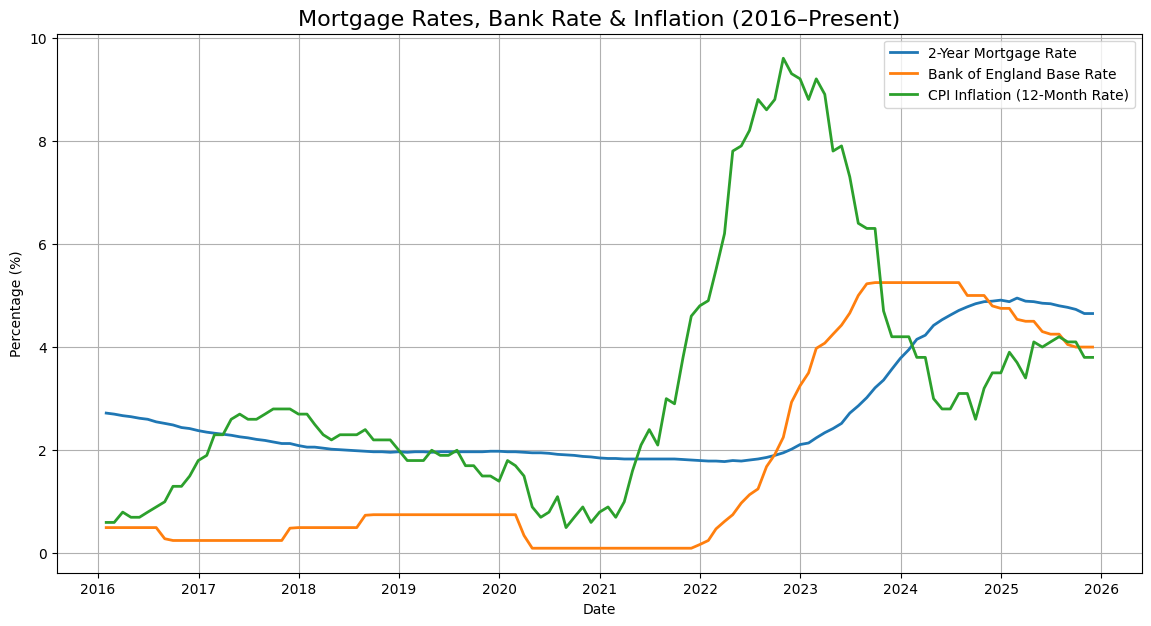

In [94]:
import matplotlib.pyplot as plt

# Plot the three key series to understand how they behave over time.
plt.figure(figsize=(14,7))

plt.plot(df_master['date'], df_master['mortgage_rate_2yr'], 
         label='2-Year Mortgage Rate', linewidth=2)

plt.plot(df_master['date'], df_master['bank_rate'],
         label='Bank of England Base Rate', linewidth=2)

plt.plot(df_master['date'], df_master['inflation_cpi_12m'], 
         label='CPI Inflation (12-Month Rate)', linewidth=2)

# Add titles and labels to make the chart easier to interpret
plt.title("Mortgage Rates, Bank Rate & Inflation (2016–Present)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(True)
plt.show()


In [95]:
# Look at correlations between the three variables to quantify how closely they move together.
correlation_matrix = df_master[['bank_rate', 
                                'mortgage_rate_2yr', 
                                'inflation_cpi_12m']].corr()

correlation_matrix


,bank_rate,mortgage_rate_2yr,inflation_cpi_12m
bank_rate,1.000000,0.827778,0.478455
mortgage_rate_2yr,0.827778,1.000000,0.077132
inflation_cpi_12m,0.478455,0.077132,1.000000


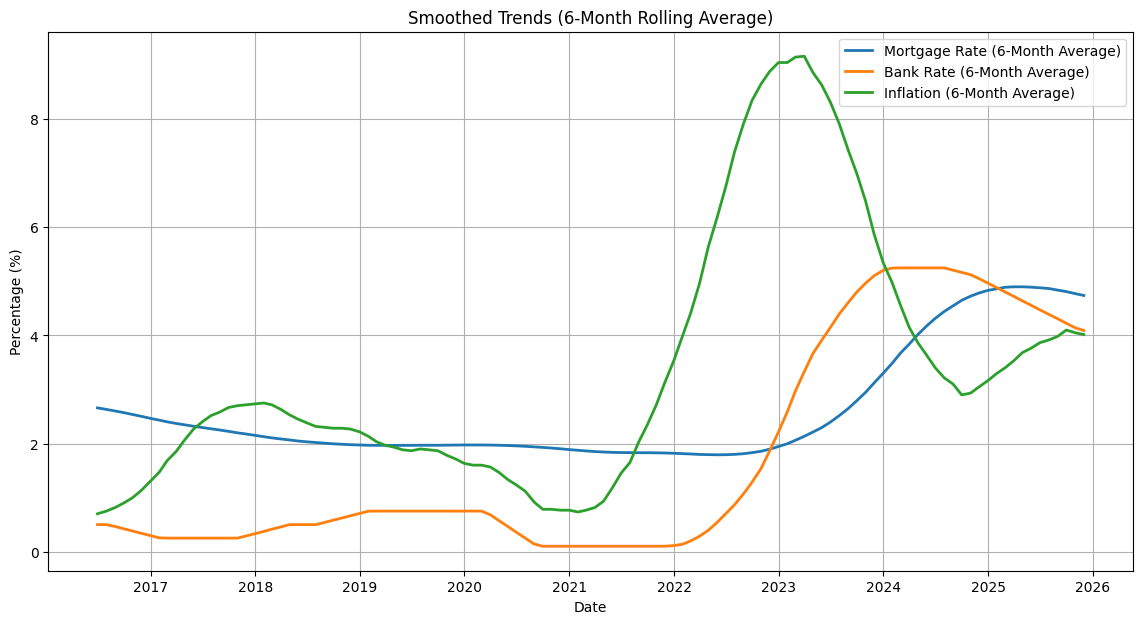

In [96]:
# Create rolling averages to smooth the data and highlight longer-term trends.
df_master['mortgage_ma_6'] = df_master['mortgage_rate_2yr'].rolling(window=6).mean()
df_master['bank_rate_ma_6'] = df_master['bank_rate'].rolling(window=6).mean()
df_master['inflation_ma_6'] = df_master['inflation_cpi_12m'].rolling(window=6).mean()

# Plot the smoothed trends
plt.figure(figsize=(14,7))

plt.plot(df_master['date'], df_master['mortgage_ma_6'], 
         label='Mortgage Rate (6-Month Average)', linewidth=2)

plt.plot(df_master['date'], df_master['bank_rate_ma_6'], 
         label='Bank Rate (6-Month Average)', linewidth=2)

plt.plot(df_master['date'], df_master['inflation_ma_6'], 
         label='Inflation (6-Month Average)', linewidth=2)

plt.title("Smoothed Trends (6-Month Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# Create lag features to see if mortgage rates react to Bank Rate changes with a delay.
df_master['bank_rate_lag1'] = df_master['bank_rate'].shift(1)  # 1-month delay
df_master['bank_rate_lag2'] = df_master['bank_rate'].shift(2)  # 2-month delay
df_master['bank_rate_lag3'] = df_master['bank_rate'].shift(3)  # 3-month delay

# Compare correlations to see which lag matches mortgage movements best.
lag_corr = df_master[['mortgage_rate_2yr', 
                      'bank_rate', 
                      'bank_rate_lag1', 
                      'bank_rate_lag2', 
                      'bank_rate_lag3']].corr()

lag_corr


,mortgage_rate_2yr,bank_rate,bank_rate_lag1,bank_rate_lag2,bank_rate_lag3
mortgage_rate_2yr,1.000000,0.827778,0.853183,0.877198,0.899649
bank_rate,0.827778,1.000000,0.997598,0.992157,0.984059
bank_rate_lag1,0.853183,0.997598,1.000000,0.997573,0.992076
bank_rate_lag2,0.877198,0.992157,0.997573,1.000000,0.997547
bank_rate_lag3,0.899649,0.984059,0.992076,0.997547,1.000000


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Take just the mortgage rate and turn it into a time series
ts = df_master[['date', 'mortgage_rate_2yr']].copy()

# Set date as the index for time series modelling
ts = ts.set_index('date')

# Make sure the data is monthly, using month-end frequency
ts = ts.asfreq('ME')  # 'ME' = month end, avoids the FutureWarning

# Forward fill any missing values so the model doesn't break
ts['mortgage_rate_2yr'] = ts['mortgage_rate_2yr'].ffill()

ts.head()



,mortgage_rate_2yr
date,
2016-01-31,2.72
2016-02-29,2.70
2016-03-31,2.67
2016-04-30,2.65
2016-05-31,2.62


In [99]:
# Build an ARIMA model on the 2-year mortgage rate series
model = ARIMA(ts['mortgage_rate_2yr'], order=(1, 1, 1))

# Fit the model to the historical data
model_fit = model.fit()

# Check a summary of the model (optional but useful for the assignment)
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:      mortgage_rate_2yr   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 259.318
Date:                Wed, 07 Jan 2026   AIC                           -512.635
Time:                        21:08:21   BIC                           -504.323
Sample:                    01-31-2016   HQIC                          -509.260
                         - 11-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9700      0.013     76.381      0.000       0.945       0.995
ma.L1         -0.4877      0.063     -7.790      0.000      -0.610      -0.365
sigma2         0.0007    5.2e-05     13.690      0.0

In [100]:
# I want a 10-year forecast, so that's 120 months
forecast_steps = 120

# Use get_forecast so I can also get confidence intervals
forecast_obj = model_fit.get_forecast(steps=forecast_steps)

# Point forecasts
forecast_mean = forecast_obj.predicted_mean

# Confidence intervals (e.g. 95%)
forecast_ci = forecast_obj.conf_int(alpha=0.05)  # 5% → 95% interval

# Build a date index for the forecast period
last_date = ts.index[-1]
forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1),
                               periods=forecast_steps,
                               freq='ME')

# Align forecast series and confidence intervals with the new dates
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index



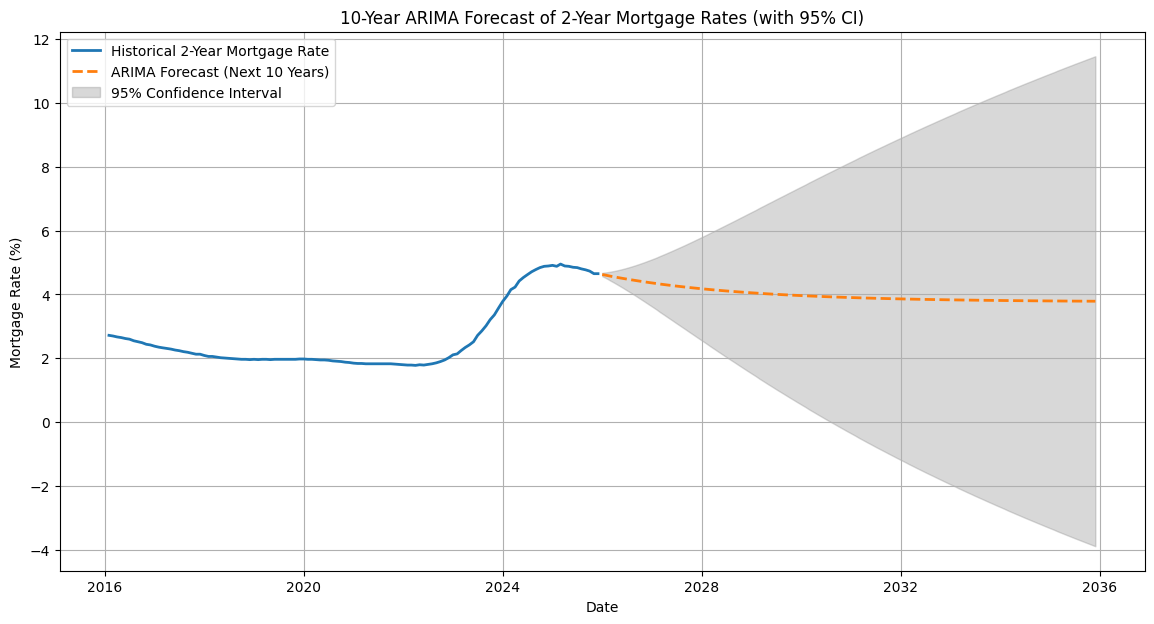

In [101]:
plt.figure(figsize=(14, 7))

# Plot historical mortgage rates
plt.plot(ts.index, ts['mortgage_rate_2yr'], 
         label="Historical 2-Year Mortgage Rate", linewidth=2)

# Plot the forecast line
plt.plot(forecast_mean.index, forecast_mean, 
         label="ARIMA Forecast (Next 10 Years)", 
         linestyle="--", linewidth=2)

# Plot the confidence interval as a shaded area
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],  # lower bound
                 forecast_ci.iloc[:, 1],  # upper bound
                 color='grey', alpha=0.3,
                 label="95% Confidence Interval")

plt.title("10-Year ARIMA Forecast of 2-Year Mortgage Rates (with 95% CI)")
plt.xlabel("Date")
plt.ylabel("Mortgage Rate (%)")
plt.grid(True)
plt.legend()
plt.show()



In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Take only the mortgage rate and set up a proper time series
ts = df_master[['date', 'mortgage_rate_2yr']].copy()

# Use the date column as the index
ts = ts.set_index('date')

# Make sure the time series is monthly (month-end)
ts = ts.asfreq('ME')

# Fill any missing values so the ARIMA model runs smoothly
ts['mortgage_rate_2yr'] = ts['mortgage_rate_2yr'].ffill()

ts.head()


,mortgage_rate_2yr
date,
2016-01-31,2.72
2016-02-29,2.70
2016-03-31,2.67
2016-04-30,2.65
2016-05-31,2.62


In [103]:
# Build the ARIMA model - using (1,1,1) as a reasonable starting point
model = ARIMA(ts['mortgage_rate_2yr'], order=(1, 1, 1))

# Fit the model to the full historical dataset
model_fit = model.fit()

# Optional: print the model summary for diagnostics
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:      mortgage_rate_2yr   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 259.318
Date:                Wed, 07 Jan 2026   AIC                           -512.635
Time:                        21:08:22   BIC                           -504.323
Sample:                    01-31-2016   HQIC                          -509.260
                         - 11-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9700      0.013     76.381      0.000       0.945       0.995
ma.L1         -0.4877      0.063     -7.790      0.000      -0.610      -0.365
sigma2         0.0007    5.2e-05     13.690      0.0

In [104]:
# A 3-year forecast = 36 months
forecast_steps = 36

# Use get_forecast so we also get confidence intervals
forecast_obj = model_fit.get_forecast(steps=forecast_steps)

# Extract the point forecasts
forecast_mean = forecast_obj.predicted_mean

# Extract lower and upper confidence bounds
forecast_ci = forecast_obj.conf_int(alpha=0.05)  # 95% interval

# Build the date index for the future period
last_date = ts.index[-1]
forecast_index = pd.date_range(
    last_date + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq='ME'
)

# Assign the correct datetime index
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index


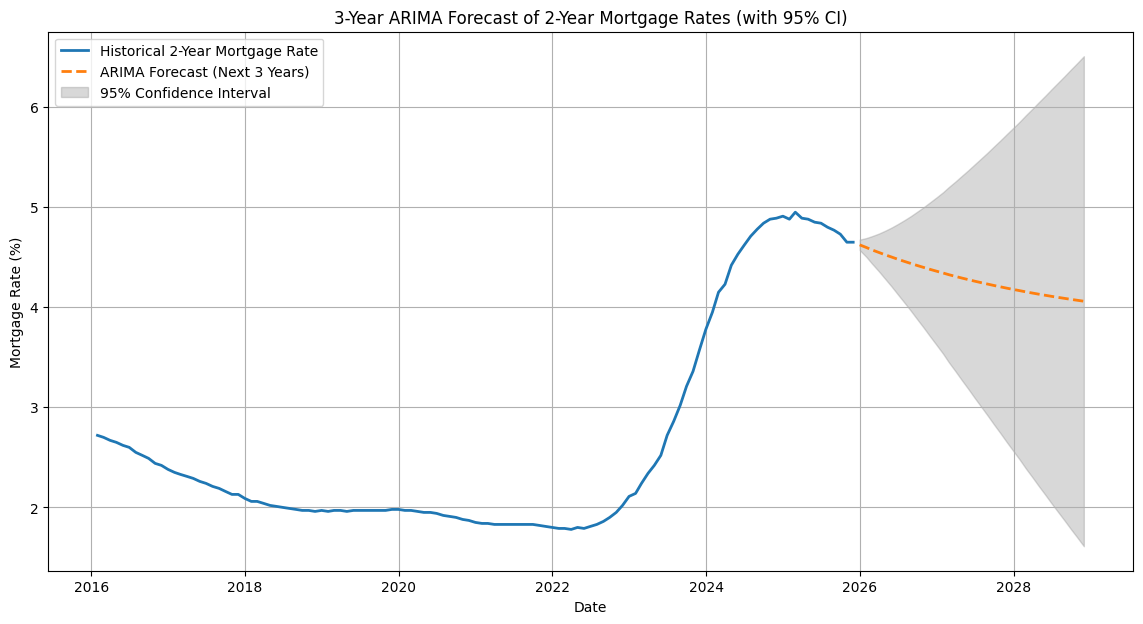

In [105]:
plt.figure(figsize=(14, 7))

# Plot historical 2-year mortgage rates
plt.plot(ts.index, ts['mortgage_rate_2yr'], 
         label="Historical 2-Year Mortgage Rate", linewidth=2)

# Plot the forecast (dashed line)
plt.plot(forecast_mean.index, forecast_mean, 
         label="ARIMA Forecast (Next 3 Years)", 
         linestyle="--", linewidth=2)

# Add confidence interval shading
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],  # lower bound
    forecast_ci.iloc[:, 1],  # upper bound
    color='grey', alpha=0.3,
    label="95% Confidence Interval"
)

plt.title("3-Year ARIMA Forecast of 2-Year Mortgage Rates (with 95% CI)")
plt.xlabel("Date")
plt.ylabel("Mortgage Rate (%)")
plt.grid(True)
plt.legend()
plt.show()


In [106]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Use the mortgage rate time series with the date index already set
ts = df_master[['date', 'mortgage_rate_2yr']].copy()
ts = ts.set_index('date')
ts = ts.asfreq('ME')
ts['mortgage_rate_2yr'] = ts['mortgage_rate_2yr'].ffill()


In [107]:
# 12-month test set
train = ts.iloc[:-12]
test = ts.iloc[-12:]


In [108]:
# Fit autoregressive model using 12 previous months to predict next month
ar_model = AutoReg(train['mortgage_rate_2yr'], lags=12).fit()

print(ar_model.summary())


                            AutoReg Model Results                             
Dep. Variable:      mortgage_rate_2yr   No. Observations:                  107
Model:                    AutoReg(12)   Log Likelihood                 241.040
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Wed, 07 Jan 2026   AIC                           -454.080
Time:                        21:08:22   BIC                           -418.325
Sample:                    01-31-2017   HQIC                          -439.632
                         - 11-30-2024                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0262      0.017      1.551      0.121      -0.007       0.059
mortgage_rate_2yr.L1      1.1190      0.103     10.906      0.000       0.918       1.320
mortgage

In [109]:
# Forecast the next 12 months
ar_forecast = ar_model.predict(
    start=test.index[0],
    end=test.index[-1]
)


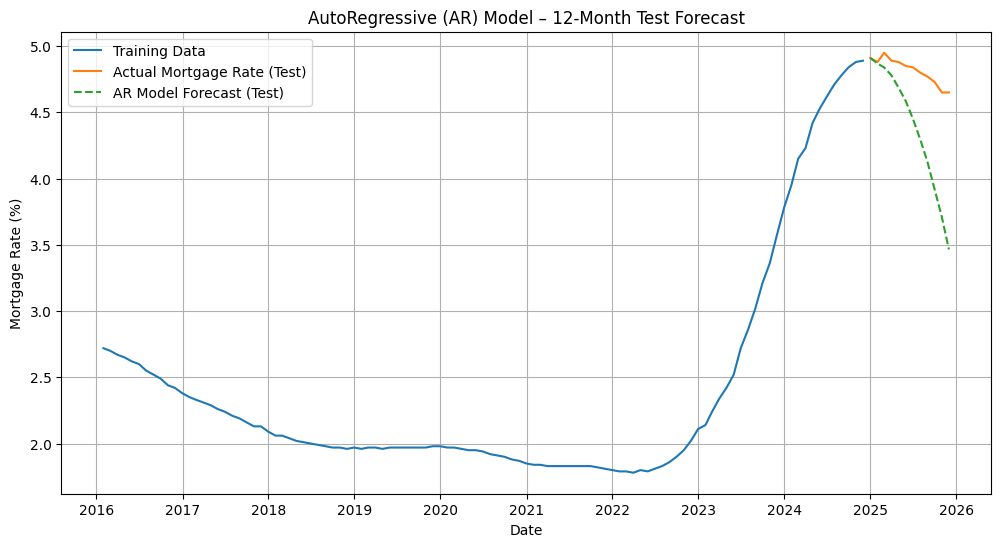

In [110]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train['mortgage_rate_2yr'], label='Training Data')
plt.plot(test.index, test['mortgage_rate_2yr'], label='Actual Mortgage Rate (Test)')
plt.plot(ar_forecast.index, ar_forecast, label='AR Model Forecast (Test)', linestyle='--')

plt.title("AutoRegressive (AR) Model – 12-Month Test Forecast")
plt.ylabel("Mortgage Rate (%)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()


In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['mortgage_rate_2yr'], ar_forecast)
rmse = np.sqrt(mean_squared_error(test['mortgage_rate_2yr'], ar_forecast))

print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))


MAE: 0.43
RMSE: 0.569


In [112]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Use the monthly mortgage dataset and set the date index
ts = df_master[['date', 'mortgage_rate_2yr']].copy()
ts = ts.set_index('date')

# Make sure it's monthly frequency (month end)
ts = ts.asfreq('ME')

# Forward-fill any tiny missing values so the model runs smoothly
ts['mortgage_rate_2yr'] = ts['mortgage_rate_2yr'].ffill()

ts.head()


,mortgage_rate_2yr
date,
2016-01-31,2.72
2016-02-29,2.70
2016-03-31,2.67
2016-04-30,2.65
2016-05-31,2.62


In [113]:
# Hold out the last 36 months for testing (3 years)
train = ts.iloc[:-36]
test = ts.iloc[-36:]

train.shape, test.shape


((83, 1), (36, 1))

In [114]:
# Fit ARIMA(1,1,1) - a solid baseline model for economic time-series
arima_model = ARIMA(train['mortgage_rate_2yr'], order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:      mortgage_rate_2yr   No. Observations:                   83
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 249.024
Date:                Wed, 07 Jan 2026   AIC                           -492.049
Time:                        21:08:22   BIC                           -484.829
Sample:                    01-31-2016   HQIC                          -489.150
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9819      0.031     31.450      0.000       0.921       1.043
ma.L1         -0.5193      0.091     -5.705      0.000      -0.698      -0.341
sigma2         0.0001   1.85e-05      7.088      0.0

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [115]:
# Forecast the same number of months as the test set
forecast_steps = len(test)

arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Match forecast dates to the test period
arima_forecast.index = test.index


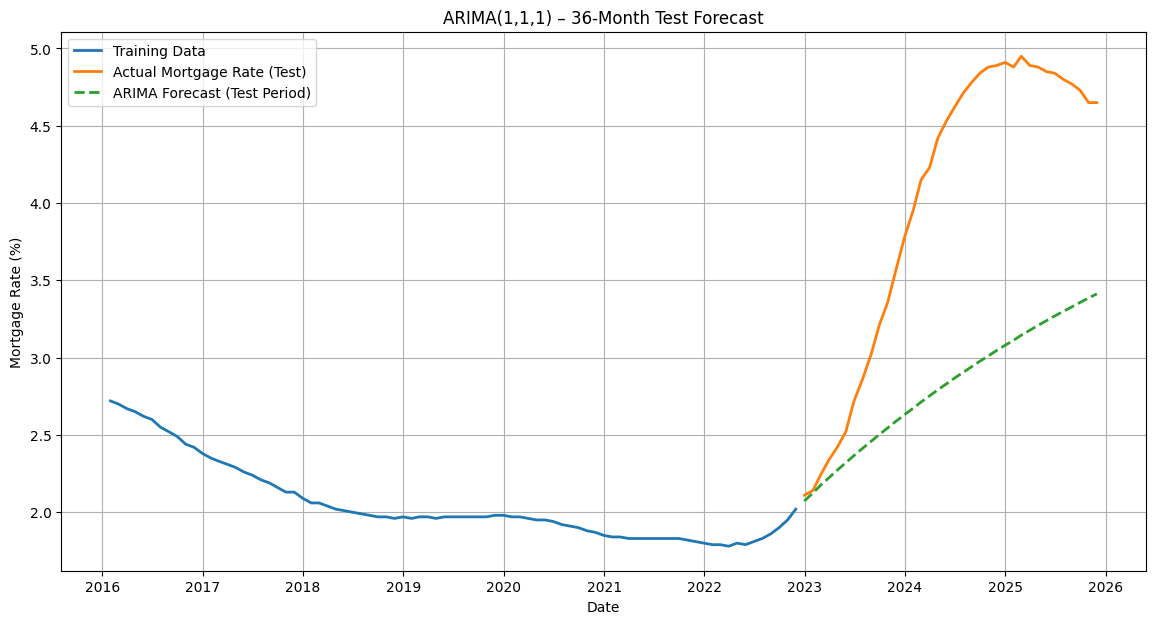

In [116]:
plt.figure(figsize=(14,7))

plt.plot(train.index, train['mortgage_rate_2yr'], 
         label='Training Data', linewidth=2)

plt.plot(test.index, test['mortgage_rate_2yr'], 
         label='Actual Mortgage Rate (Test)', linewidth=2)

plt.plot(arima_forecast.index, arima_forecast, 
         label='ARIMA Forecast (Test Period)', linestyle='--', linewidth=2)

plt.title("ARIMA(1,1,1) – 36-Month Test Forecast")
plt.xlabel("Date")
plt.ylabel("Mortgage Rate (%)")
plt.grid(True)
plt.legend()
plt.show()


In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_arima_36 = mean_absolute_error(test['mortgage_rate_2yr'], arima_forecast)
rmse_arima_36 = np.sqrt(mean_squared_error(test['mortgage_rate_2yr'], arima_forecast))

print("ARIMA 36-Month MAE:", round(mae_arima_36, 3))
print("ARIMA 36-Month RMSE:", round(rmse_arima_36, 3))


ARIMA 36-Month MAE: 1.191
ARIMA 36-Month RMSE: 1.349
